In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np

In [2]:
RX_pattern = np.load('data/RX_pattern.npy')
TX_pattern = np.load('data/TX_pattern.npy')
OMNI_pattern = np.load('data/OMNI_pattern.npy')
impulse_response = np.load('data/impulse_response.npy')
#impulse_response = np.load('data/impulse_response_NLoS.npy')
#print(impulse_response)

In [3]:
def horzontal_shift(angle, pattern): 
    if angle > 0:
        horizontal1 = pattern[:,-angle:]
        horizontal2 = pattern[:,:-angle]
        shifted_pattern = np.hstack((horizontal1, horizontal2))
        
    elif angle < 0:
        horizontal1 = pattern[:,-(360+angle):]
        horizontal2 = pattern[:,:-(360+angle)]
        shifted_pattern = np.hstack((horizontal1, horizontal2))
        
    else:
        shifted_pattern = pattern  

    return shifted_pattern

In [4]:
def vertical_shift(angle, pattern): 
    if angle > 0:
        vertical1 = pattern[-angle:,:]
        vertical2 = pattern[:-angle,:]
        shifted_pattern = np.vstack((vertical1, vertical2))
        
    elif angle < 0:
        vertical1 = pattern[-(360+angle):,:]
        vertical2 = pattern[:-(360+angle),:]
        shifted_pattern = np.vstack((vertical1, vertical2))
        
    else:
        shifted_pattern = pattern  

    return shifted_pattern

In [5]:
all_paths = impulse_response.shape[0]
TX_angles = [-90,-60,-45,-30,-15,0,15,30,45,60,90]
TX_sweep = np.zeros((all_paths, len(TX_angles)+1))
a = np.zeros((all_paths, len(TX_angles)))
i = 0

for angle in TX_angles:
    TX_pattern_shifted = horzontal_shift(angle,TX_pattern)
    
    for path_idx in range(all_paths):
        TX1 = int(impulse_response[path_idx][3])
        TX2 = int(impulse_response[path_idx][4])
        RX1 = int(impulse_response[path_idx][5])
        RX2 = int(impulse_response[path_idx][6])

        TX_sweep[path_idx][0] = impulse_response[path_idx][2]
        TX_sweep[path_idx][(i+1)] = 20*np.log10(impulse_response[path_idx][1])
        TX_sweep[path_idx][(i+1)] = TX_sweep[path_idx][(i+1)] + TX_pattern_shifted[TX1][TX2] + OMNI_pattern[RX1][RX2]
        TX_sweep[path_idx][(i+1)] = 10**(TX_sweep[path_idx][(i+1)]/20)

        a[path_idx][i] = TX_pattern_shifted[TX1][TX2]
        
    i = i + 1
    
#print(TX_sweep)

In [6]:
def angles_shift(angle): 
    if angle > 0:
        angle_axis = np.concatenate((angle_vector[-(360-angle):], angle_vector[:-(360-angle)])) 
    elif angle < 0:
        angle_axis = np.concatenate((angle_vector[-(-angle):], angle_vector[:-(-angle)]))
    else:
        angle_axis = angle_vector

    return angle_axis

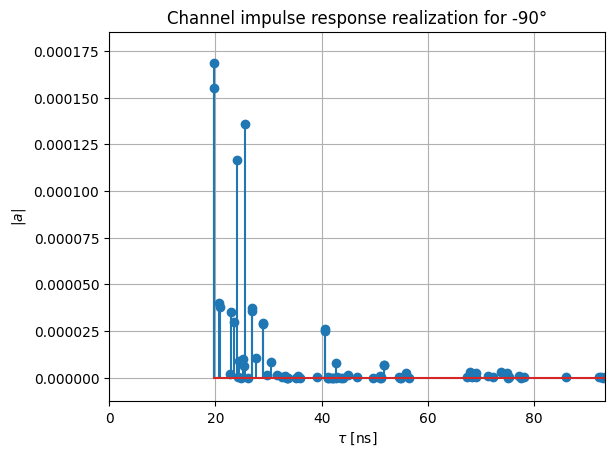

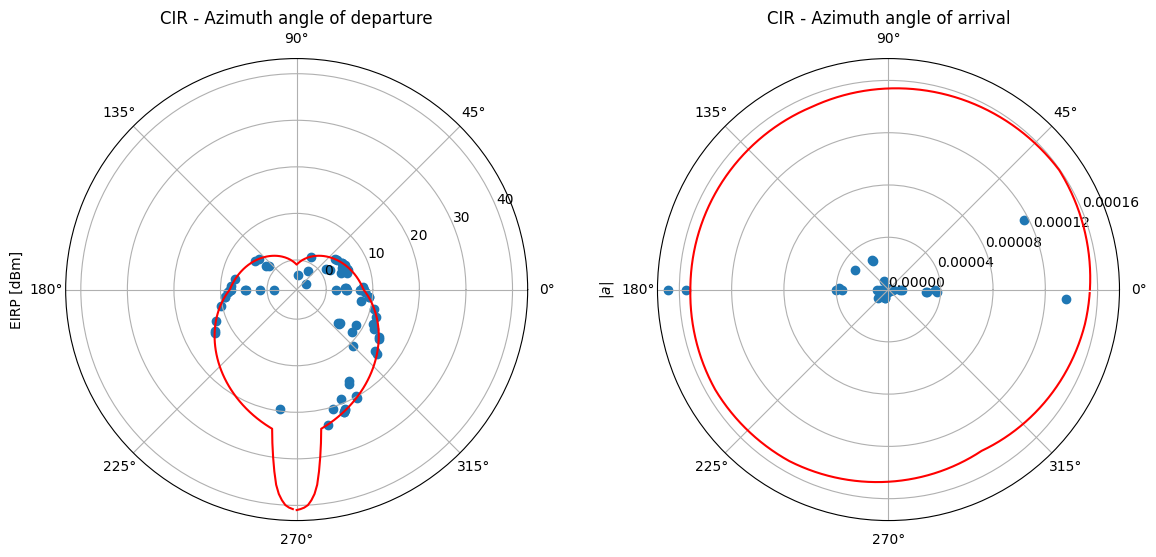

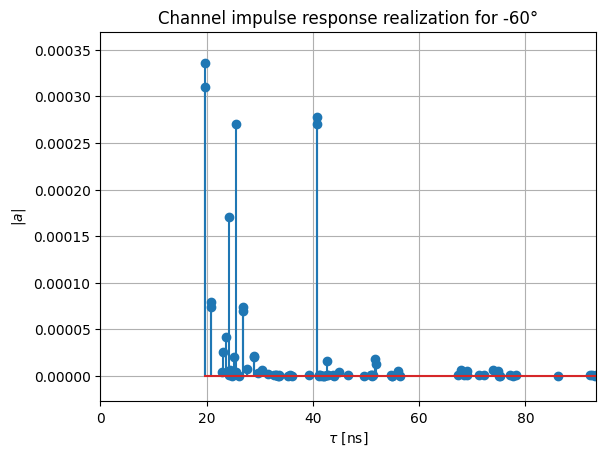

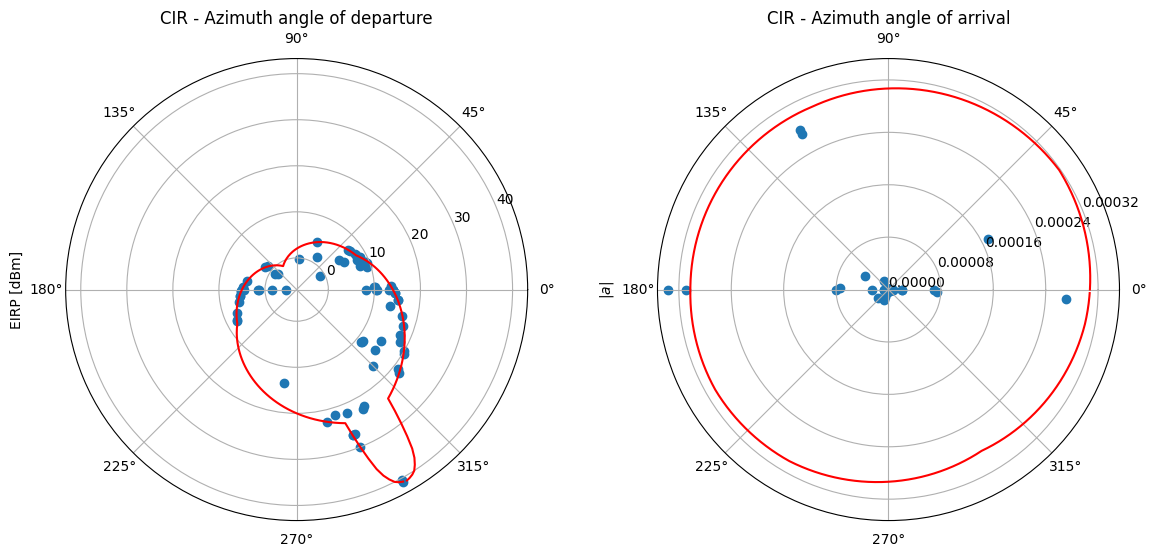

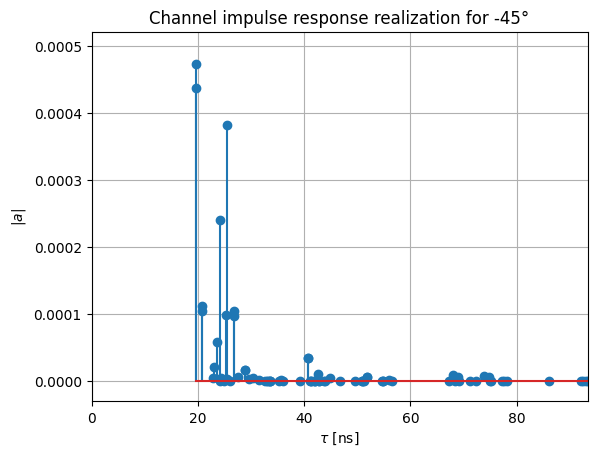

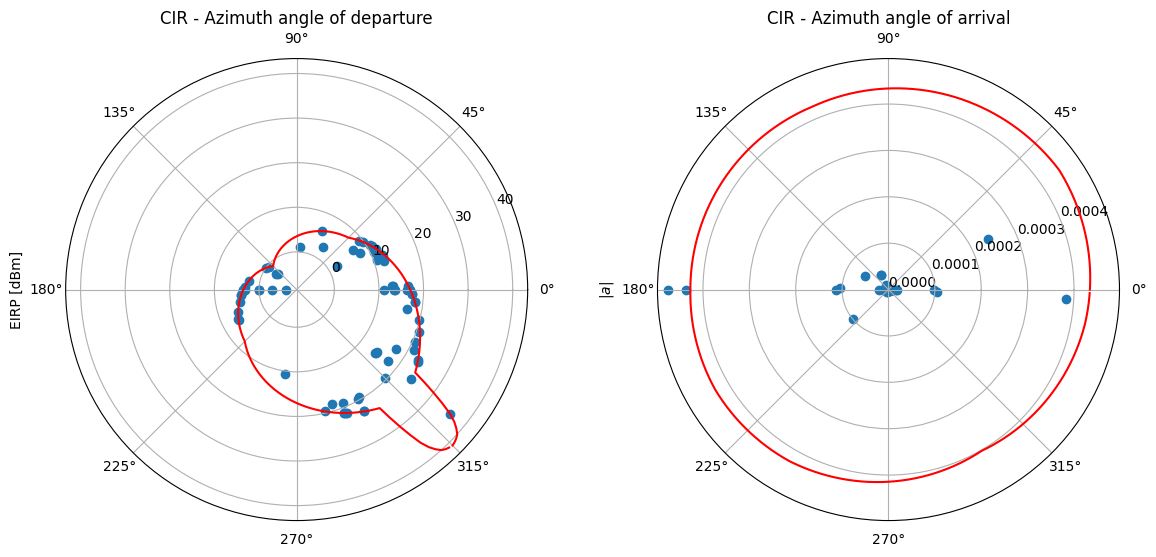

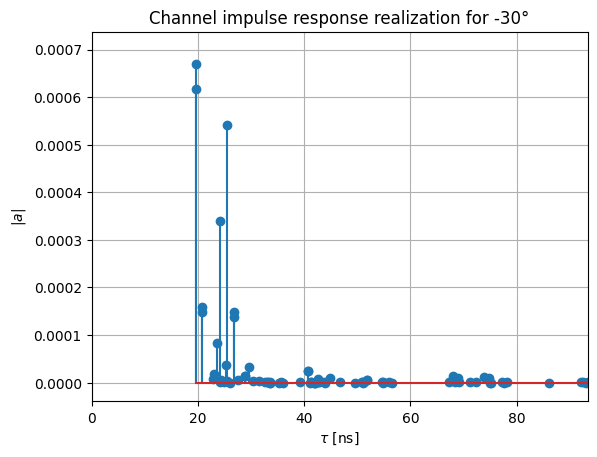

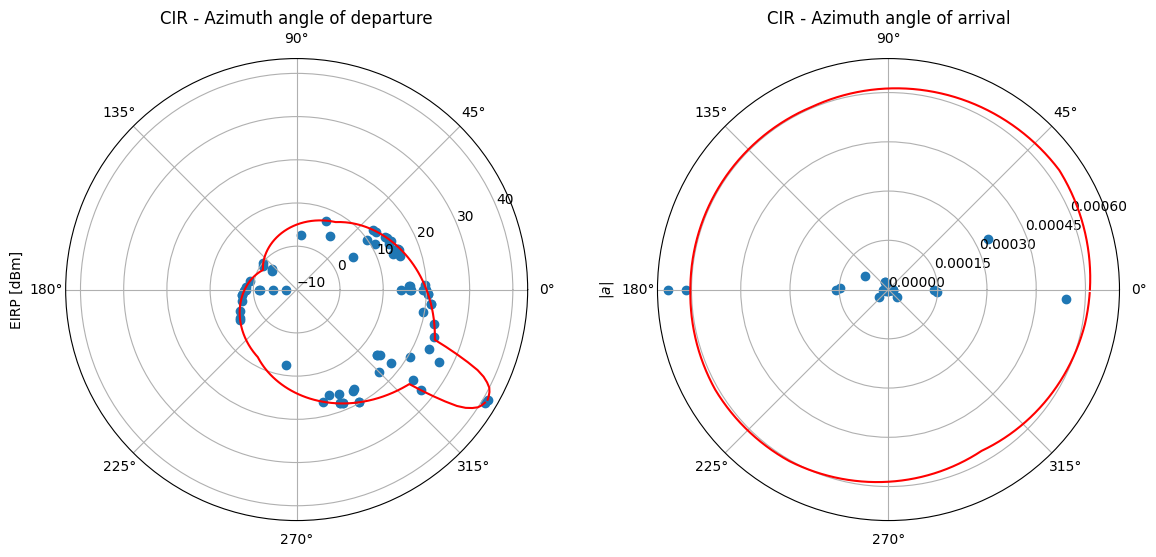

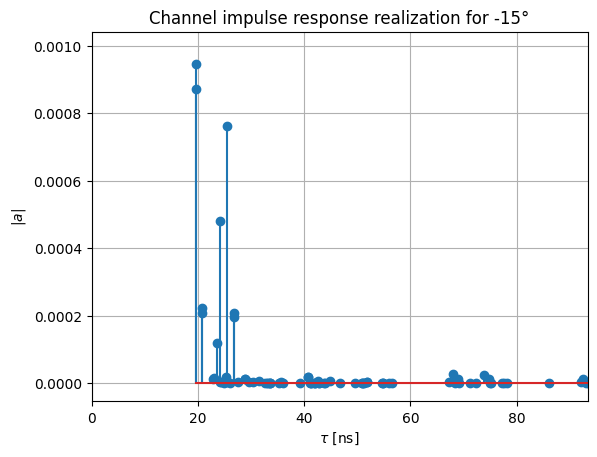

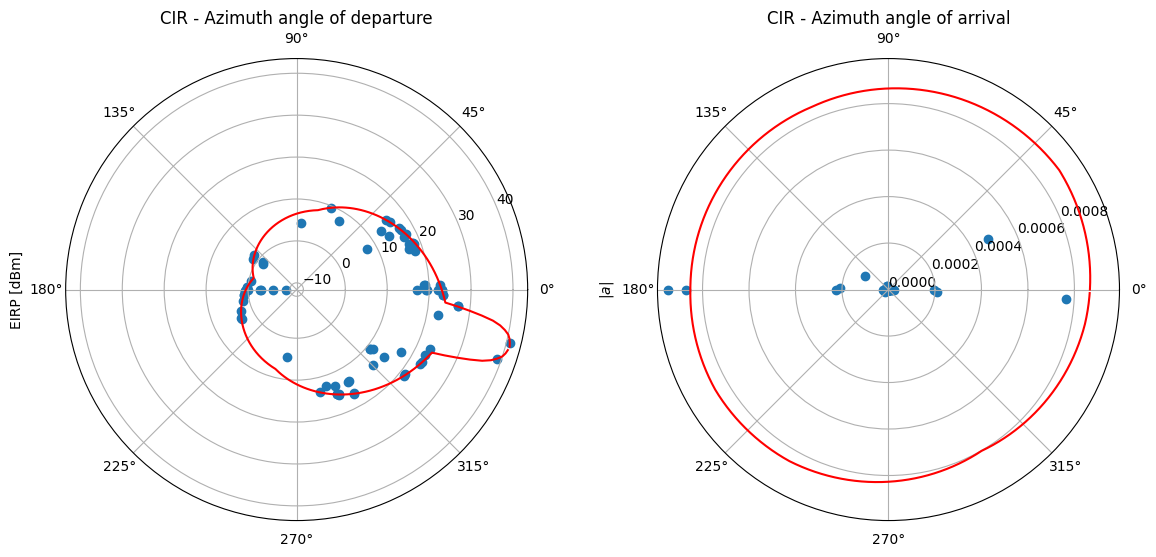

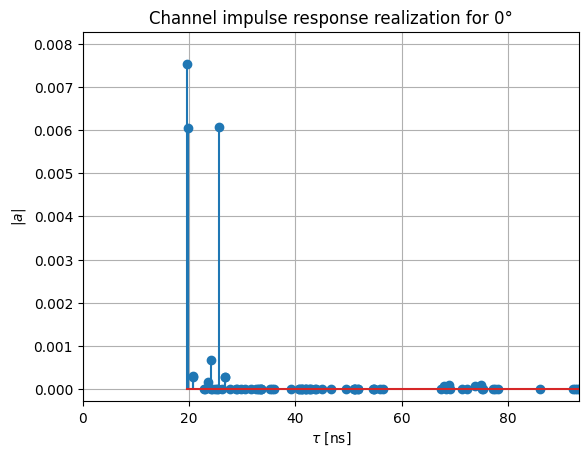

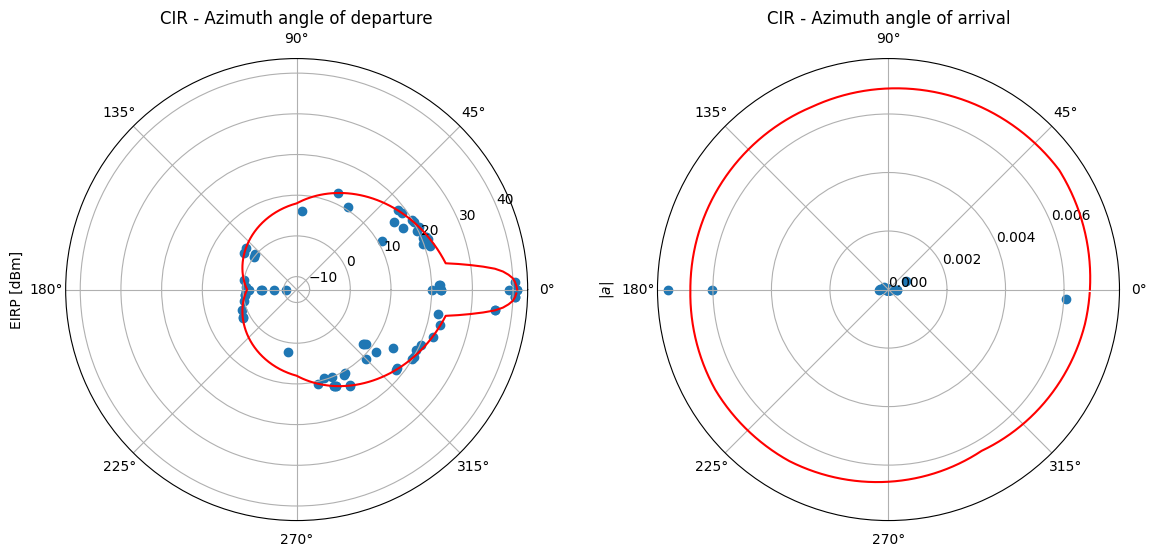

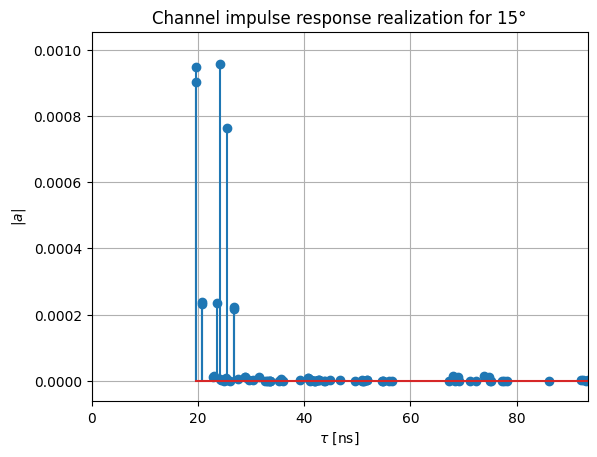

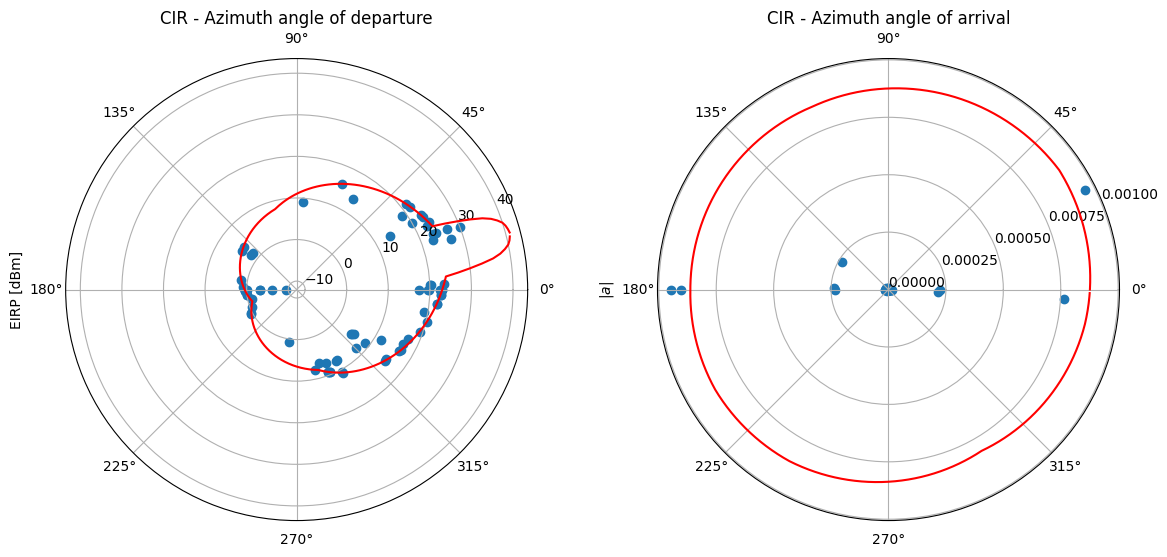

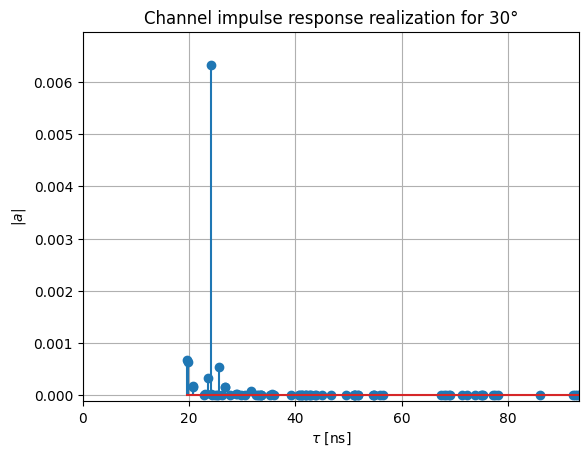

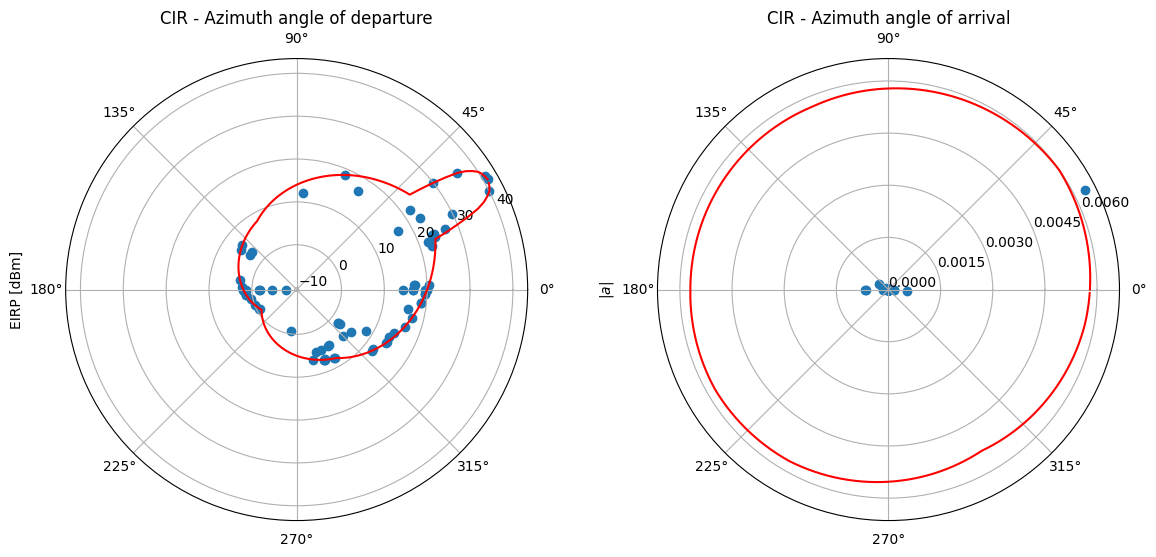

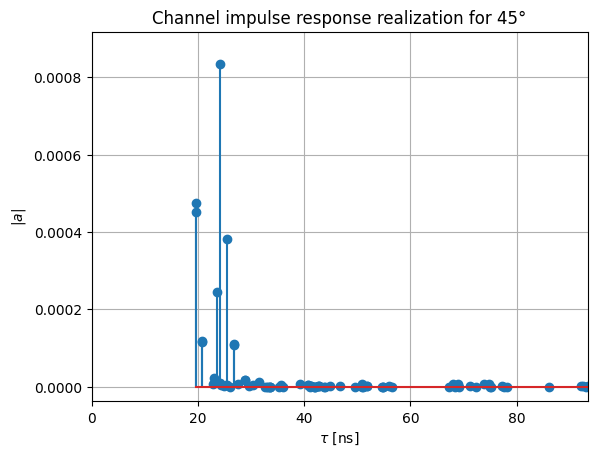

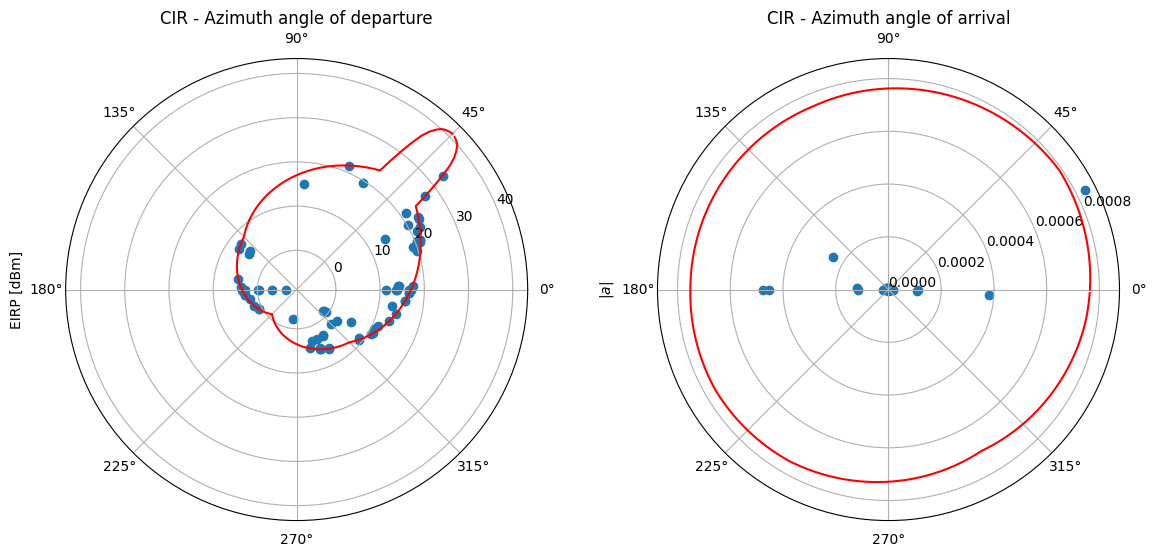

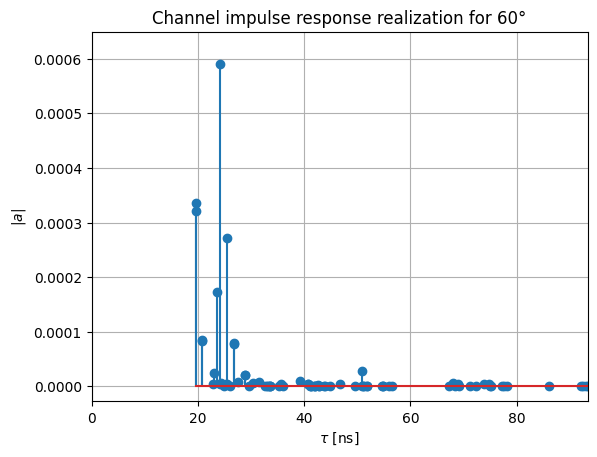

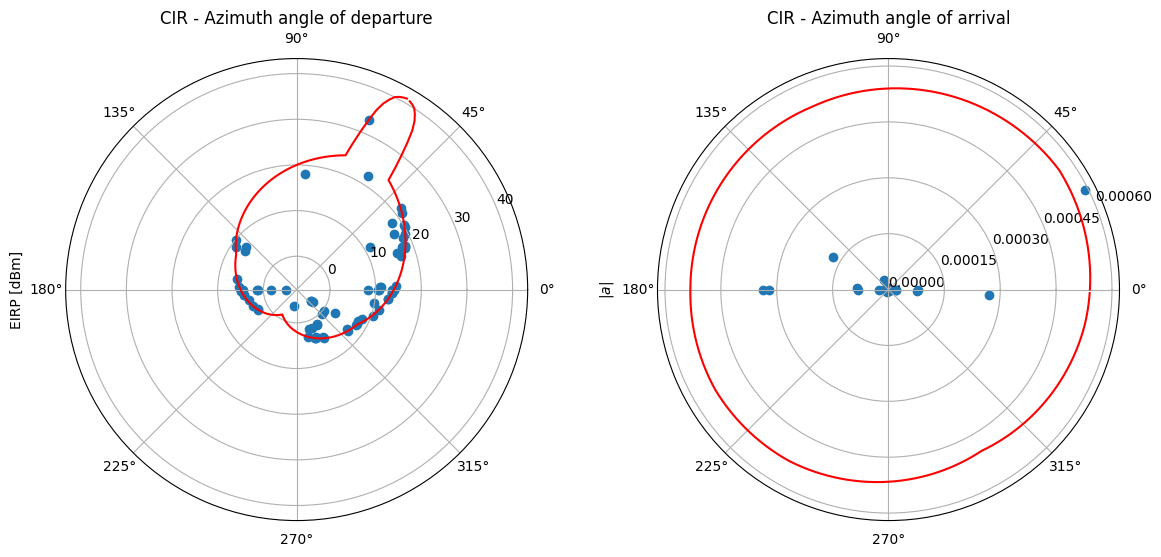

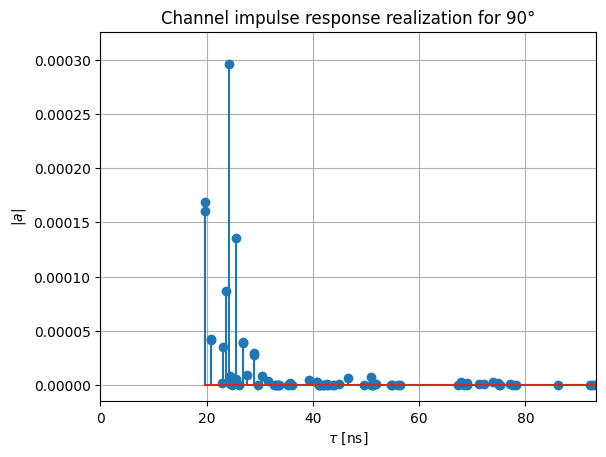

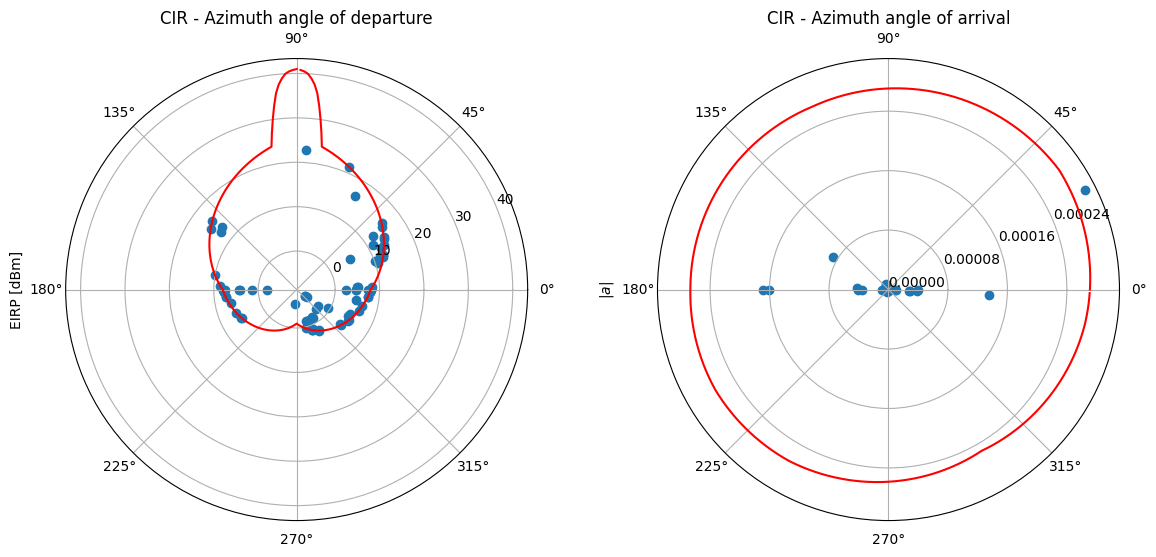

In [7]:
t = TX_sweep[:,0]/1e-9
angle_vector = np.linspace(0, 359, num=360)*np.pi/180
i=0

for angle in TX_angles: 
    angle_axis = angles_shift(angle)  
  
    # CIR time domain
    plt.figure()
    plt.title("Channel impulse response realization for " + str(int(angle)) + "°")
    plt.stem(t, TX_sweep[:,(i+1)])
    plt.xlim([0, np.max(t)])
    plt.ylim([-np.average(TX_sweep[:,(i+1)]), np.max(TX_sweep[:,(i+1)])*1.1])
    plt.xlabel(r"$\tau$ [ns]")
    plt.ylabel(r"$|a|$");
    plt.grid()

    # CIR angle domain
    fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(14, 6))

    # Plot on the first subplot
    ax1.scatter(impulse_response[:, 4] * np.pi / 180, a[:,i], label='CIR')
    ax1.plot(angle_axis, TX_pattern[90, :], color='red')
    ax1.set_title("CIR - Azimuth angle of departure")
    ax1.set_ylabel('EIRP [dBm]', labelpad=30)
    ax1.grid(True)

    # Plot on the second subplot
    ax2.scatter(impulse_response[:,6]*np.pi/180, TX_sweep[:,(i+1)])
    ax2.set_title("CIR - Azimuth angle of arrival")
    ax2.yaxis.set_major_locator(MaxNLocator(nbins=5))
    ax2.grid(True)

    ax2_secondary = fig.add_axes(ax2.get_position(), projection='polar')
    ax2_secondary.plot(angle_vector, OMNI_pattern[90, :], color='red')
    ax2.set_ylabel(r"$|a|$", labelpad=30)
    ax2_secondary.set_frame_on(False)  # Remove the frame
    ax2_secondary.yaxis.set_visible(False)  # Hide secondary axis ticks and labels
    ax2_secondary.xaxis.set_visible(False)  # Optionally hide angular axis
    ax2_secondary.set_ylim(-30, 5)

    # Show the plots
    plt.show()

    i = i + 1

In [8]:
TX_codebook = np.zeros(len(TX_angles))

for TX_angle_idx in range(len(TX_codebook)):
    TX_codebook[TX_angle_idx] = np.max(TX_sweep[:,(TX_angle_idx+1)])

max_amp_TX = np.max(TX_codebook)
max_idx_TX = np.argmax(TX_codebook)

print("Maximum amplitude is " + str(max_amp_TX) + " for TX angle " + str(TX_angles[max_idx_TX]) + "°")

Maximum amplitude is 0.007518773837352177 for TX angle 0°


In [9]:
TX_pattern_shifted = horzontal_shift(TX_angles[max_idx_TX],TX_pattern)
RX_angles_h = [-90,-60,-45,-30,-15,0,15,30,45,60,90]
RX_angles_v = [-15,0,15]
RX_sweep = np.zeros((all_paths, len(RX_angles_h)+1, len(RX_angles_v)))
a2 = np.zeros((all_paths, len(RX_angles_h), len(RX_angles_v)))
k = 0

for  angle_v in RX_angles_v:
    i = 0 
    RX_pattern_shifted_v = vertical_shift(angle_v,RX_pattern)
    
    for angle_h in RX_angles_h:
        RX_pattern_shifted = horzontal_shift(angle_h,RX_pattern_shifted_v)
       
        for path_idx in range(all_paths):
            TX1 = int(impulse_response[path_idx][3])
            TX2 = int(impulse_response[path_idx][4])
            RX1 = int(impulse_response[path_idx][5])
            RX2 = int(impulse_response[path_idx][6])

            RX_sweep[path_idx][0][k] = impulse_response[path_idx][2]
            RX_sweep[path_idx][(i+1)][k] = 20*np.log10(impulse_response[path_idx][1])
            RX_sweep[path_idx][(i+1)][k] = RX_sweep[path_idx][(i+1)][k] + TX_pattern_shifted[TX1][TX2] + RX_pattern_shifted[RX1][RX2]
            RX_sweep[path_idx][(i+1)][k] = 10**(RX_sweep[path_idx][(i+1)][k]/20)

            a2[path_idx][i][k] = TX_pattern_shifted[TX1][TX2]

        i = i + 1
        
    k = k + 1
      
#print(RX_sweep)

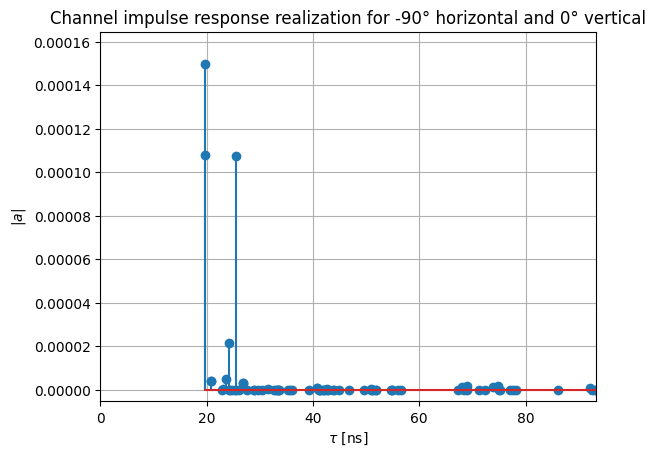

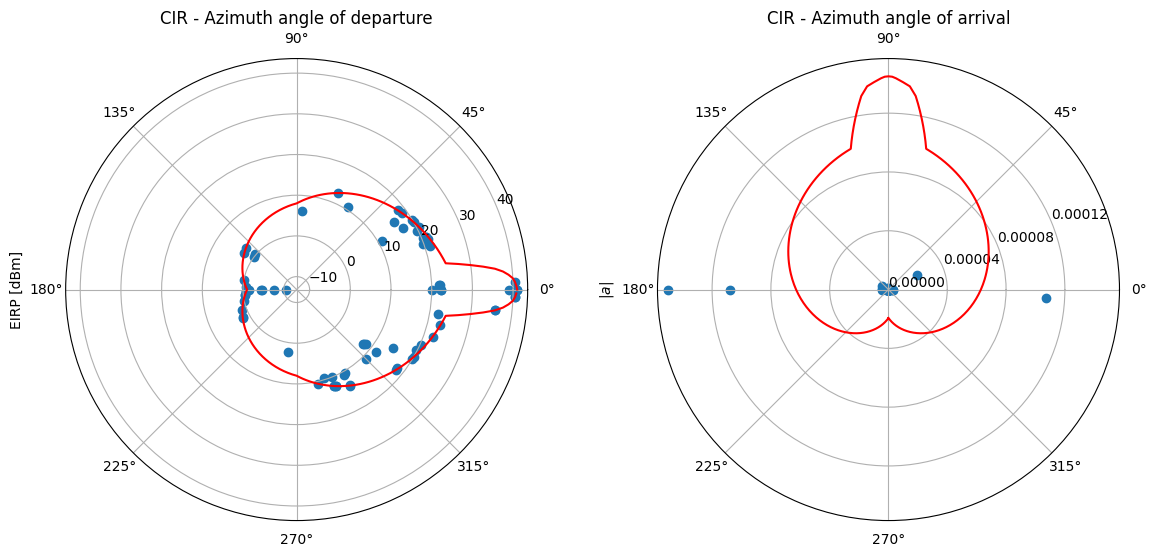

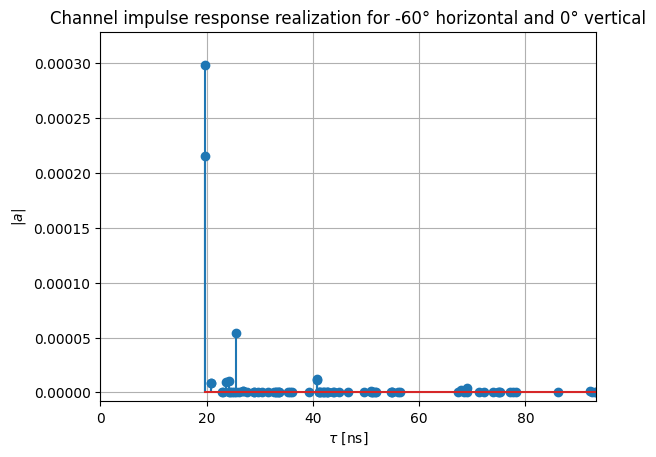

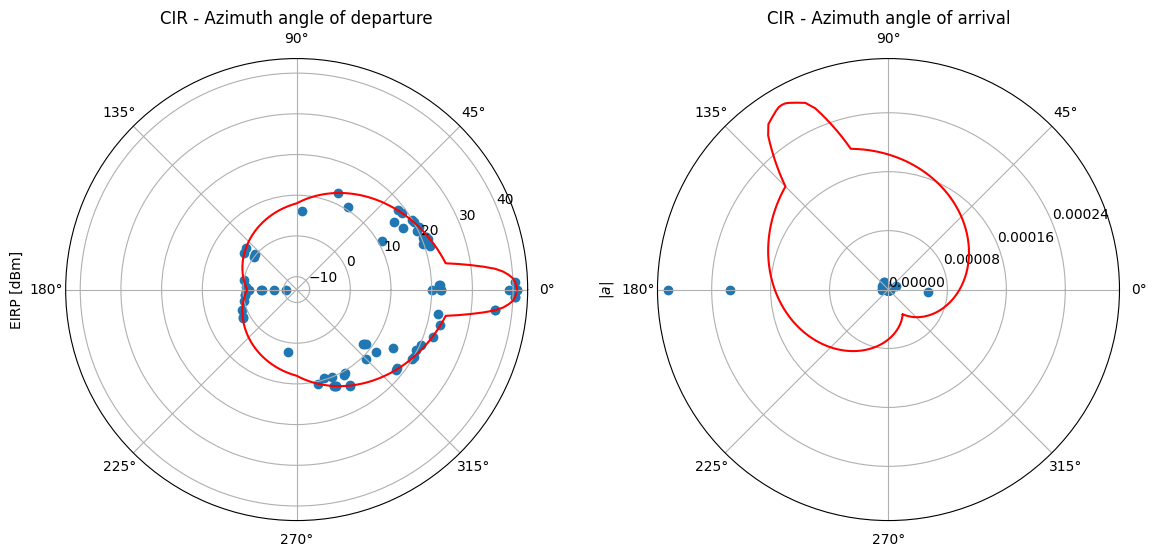

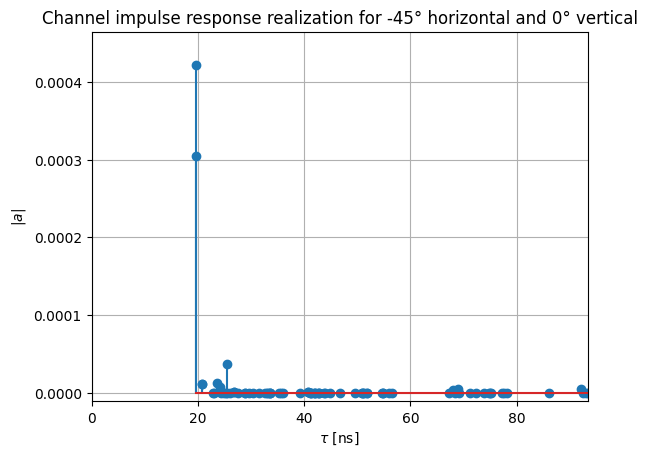

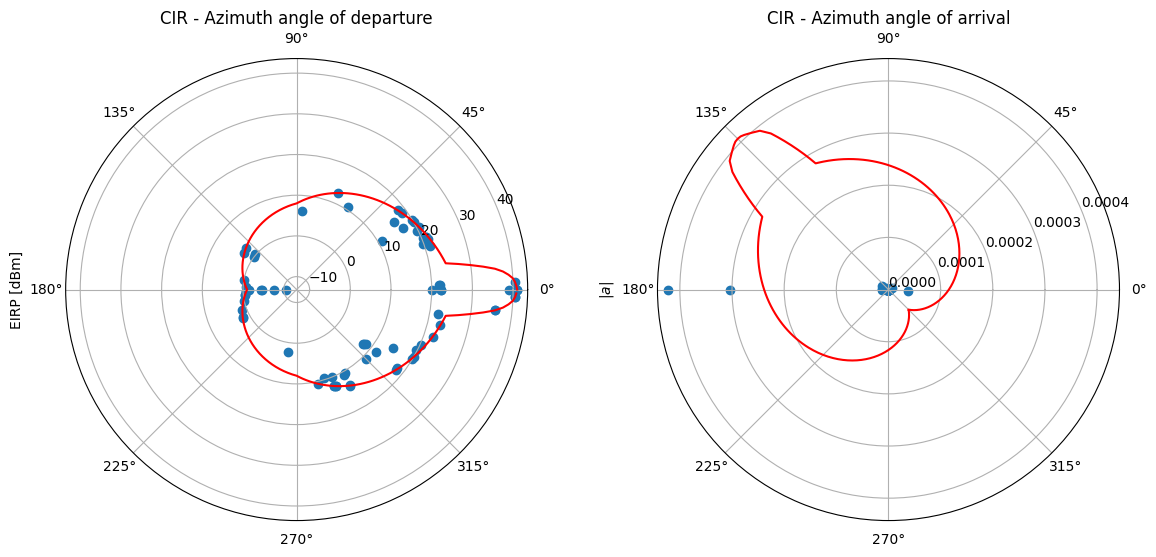

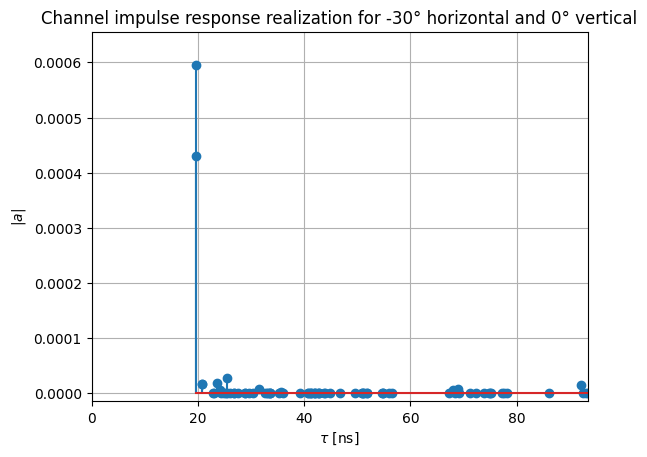

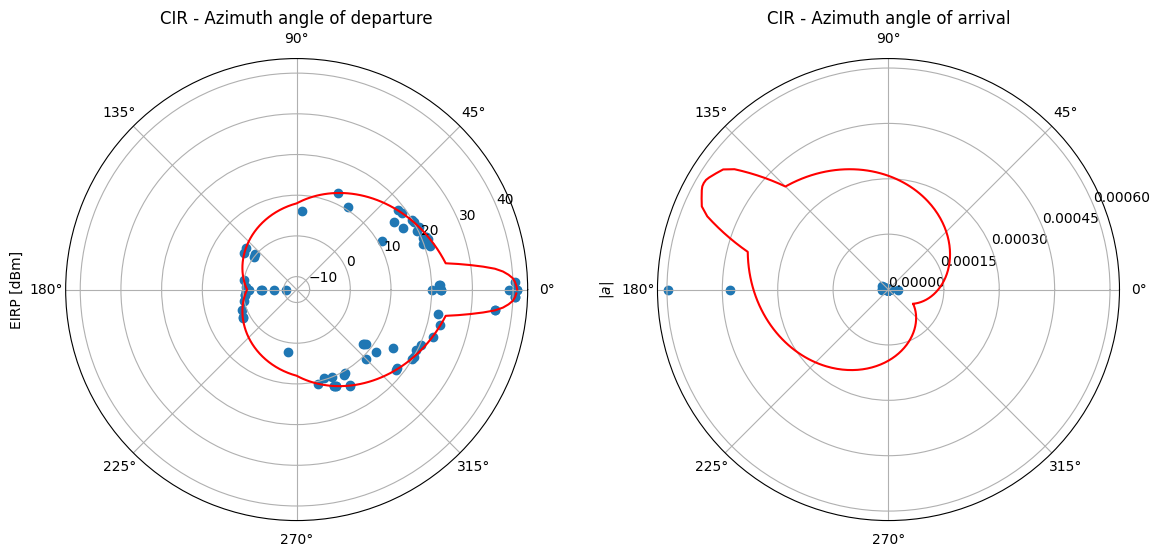

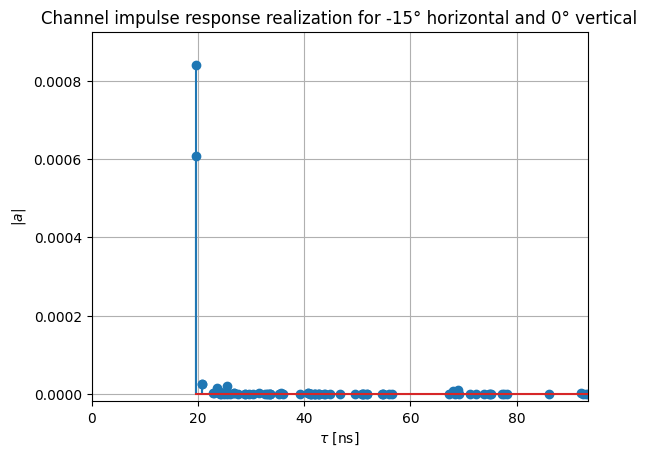

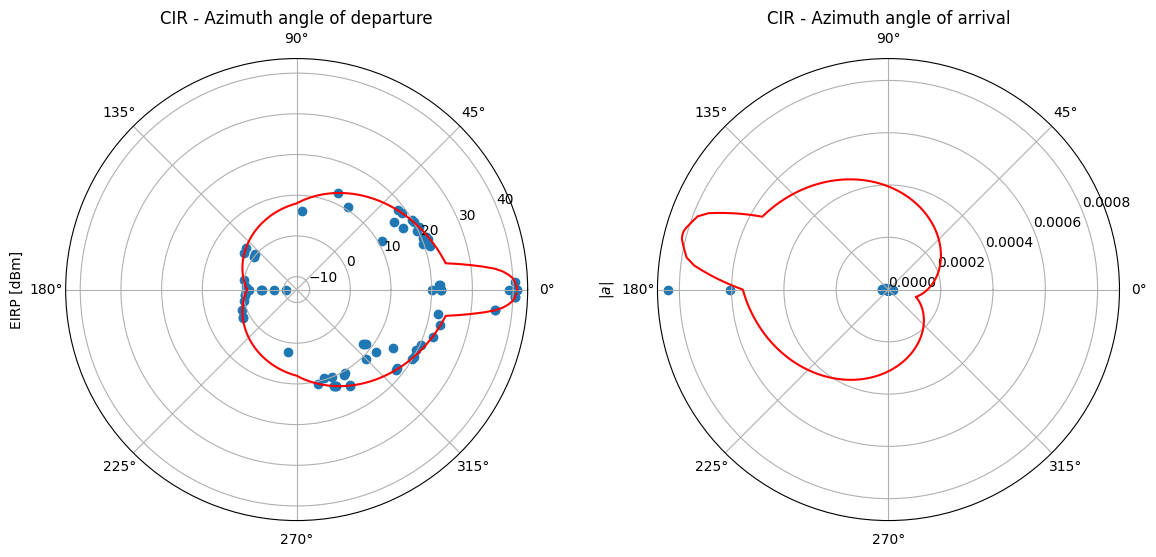

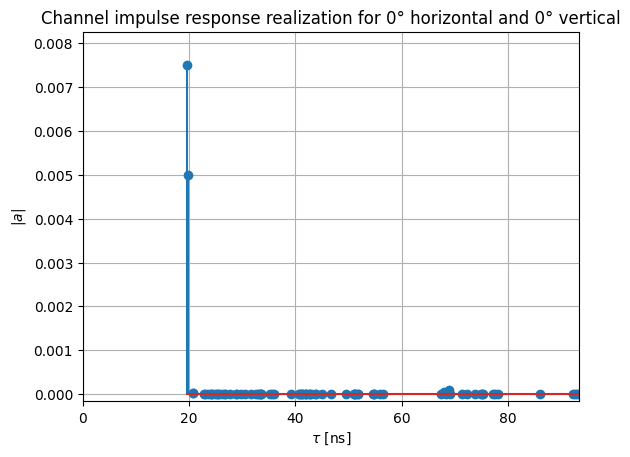

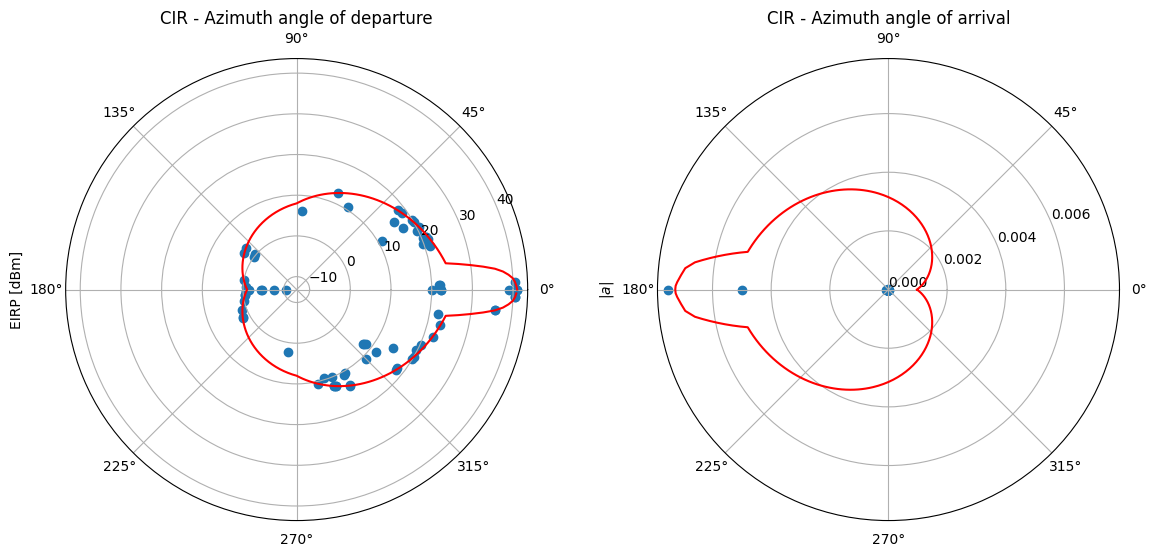

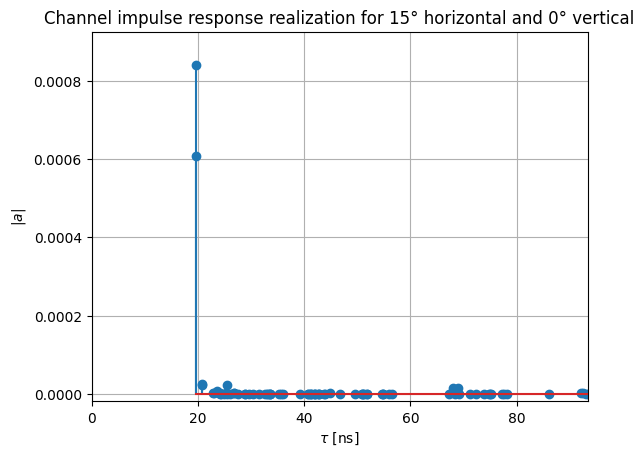

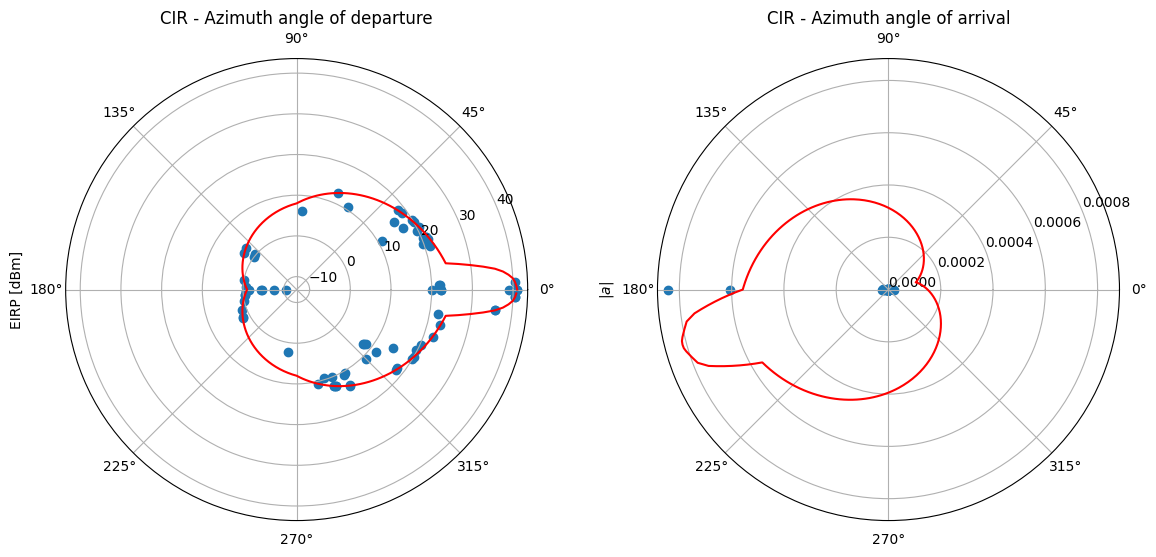

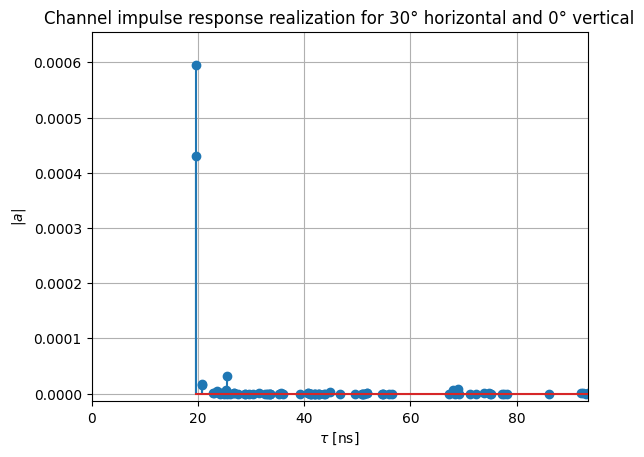

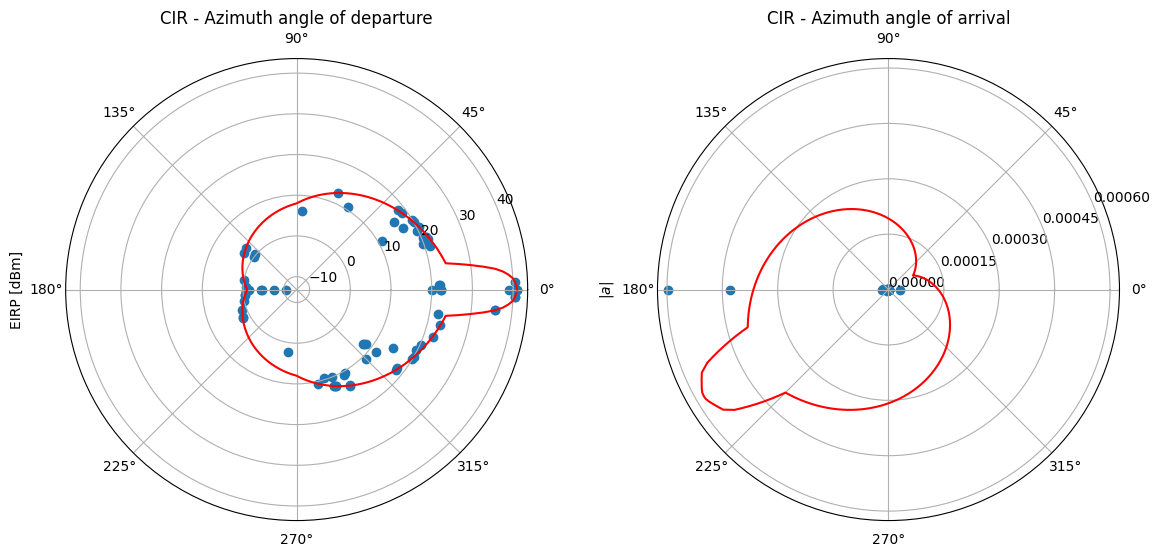

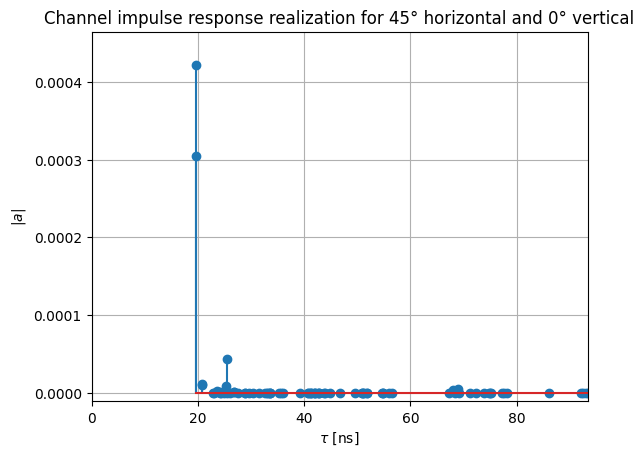

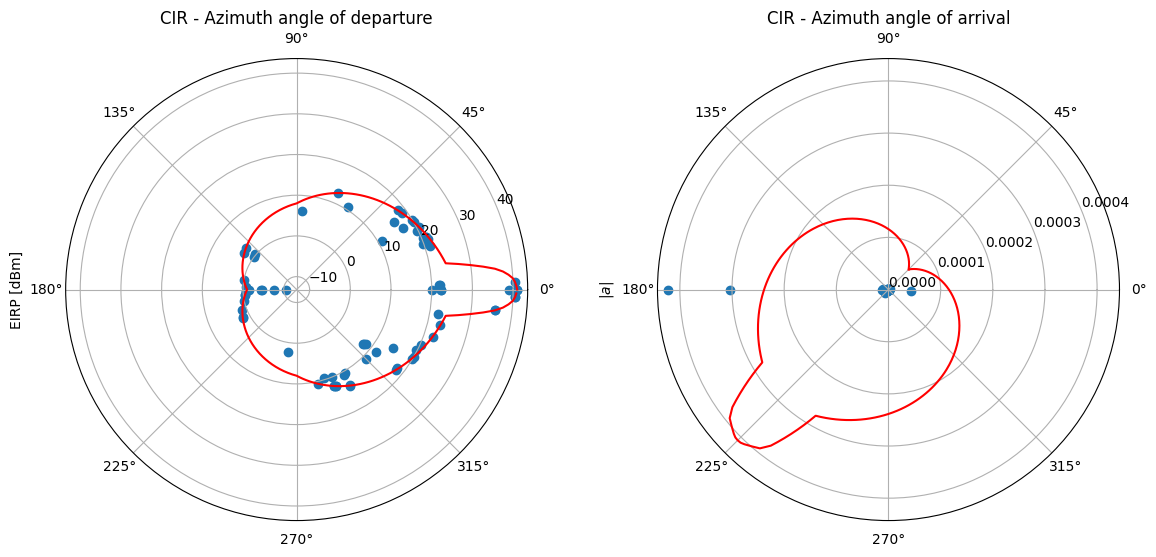

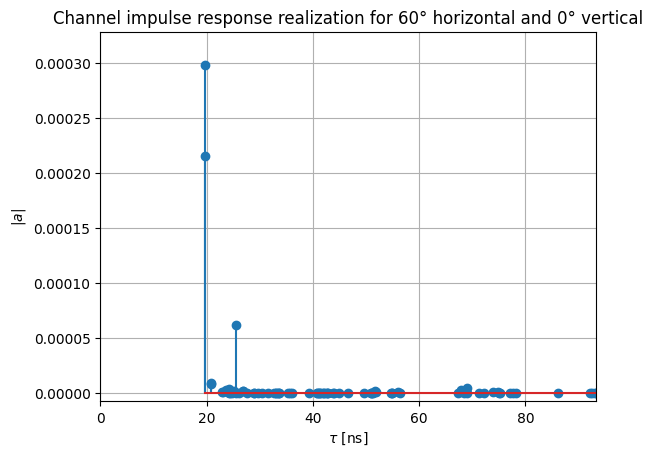

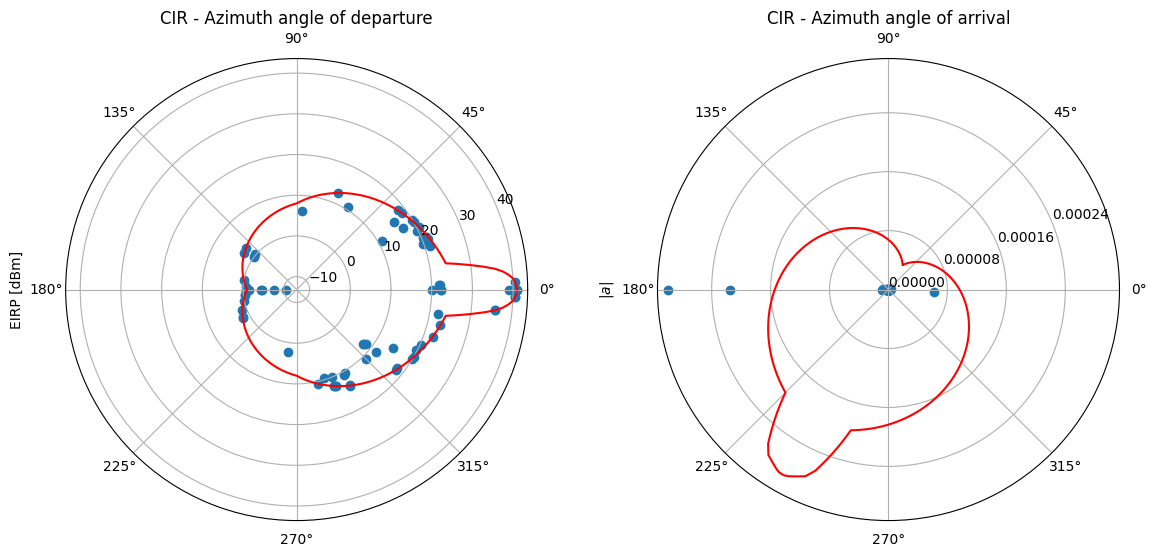

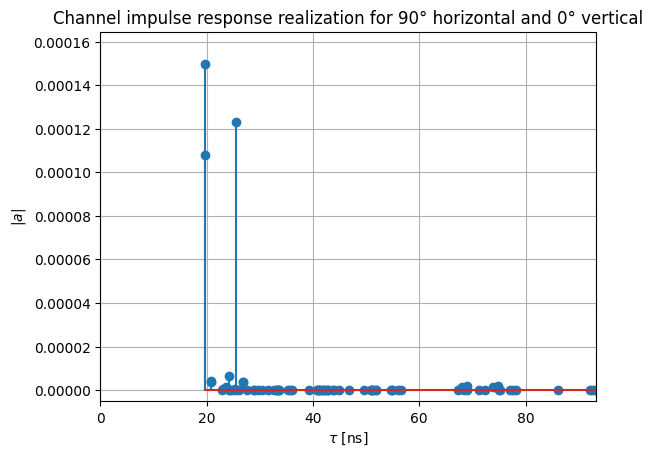

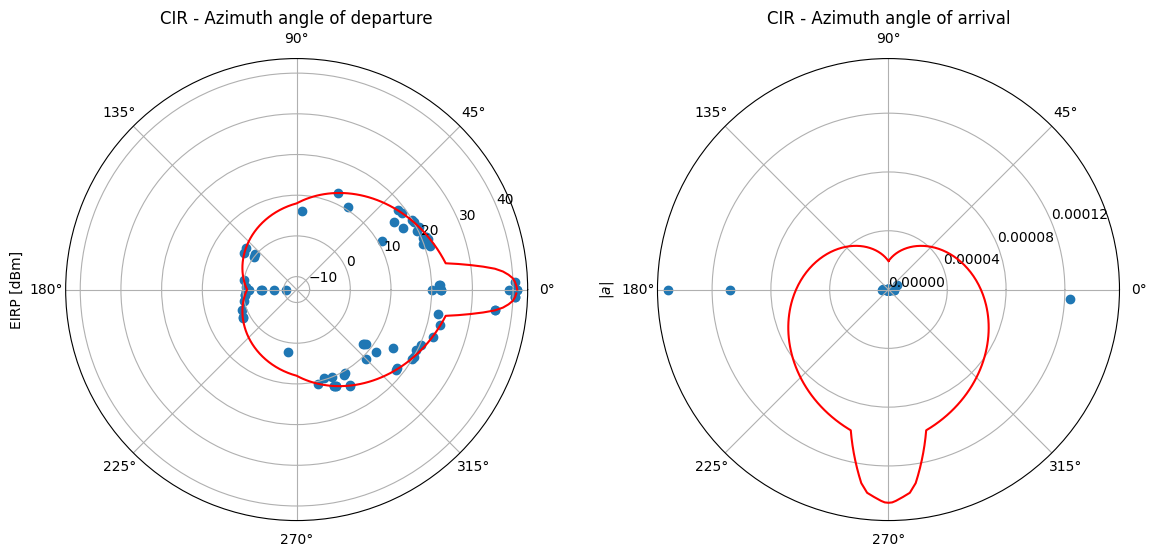

In [10]:
angle_axis_TX = angles_shift(TX_angles[max_idx_TX])
vertical_angle_position = 1
vertical_angle_value = RX_angles_v[vertical_angle_position]
i=0

for angle in RX_angles_h: 
    angle_axis_RX = angles_shift(angle) 
  
    # CIR time domain
    plt.figure()
    plt.title("Channel impulse response realization for " + str(int(angle)) + "° horizontal and " + str(int(vertical_angle_value)) + "° vertical")
    plt.stem(t, RX_sweep[:,(i+1),vertical_angle_position])
    plt.xlim([0, np.max(t)])
    plt.ylim([-np.average(RX_sweep[:,(i+1),vertical_angle_position]), np.max(RX_sweep[:,(i+1),vertical_angle_position])*1.1])
    plt.xlabel(r"$\tau$ [ns]")
    plt.ylabel(r"$|a|$");
    plt.grid()

    # CIR angle domain
    fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(14, 6))

    # Plot on the first subplot
    ax1.scatter(impulse_response[:, 4] * np.pi / 180, a2[:,i,vertical_angle_position], label='CIR')
    ax1.plot(angle_axis_TX, TX_pattern[90, :], color='red')
    ax1.set_title("CIR - Azimuth angle of departure")
    ax1.set_ylabel('EIRP [dBm]', labelpad=30)
    ax1.grid(True)

    # Plot on the second subplot
    ax2.scatter(impulse_response[:,6]*np.pi/180, RX_sweep[:,(i+1),vertical_angle_position])
    ax2.set_title("CIR - Azimuth angle of arrival")
    ax2.yaxis.set_major_locator(MaxNLocator(nbins=5))
    ax2.grid(True)

    ax2_secondary = fig.add_axes(ax2.get_position(), projection='polar')
    ax2_secondary.plot(angle_axis_RX, RX_pattern[90, :], color='red')
    ax2.set_ylabel(r"$|a|$", labelpad=30)
    ax2_secondary.set_frame_on(False)  # Remove the frame
    ax2_secondary.yaxis.set_visible(False)  # Hide secondary axis ticks and labels
    ax2_secondary.xaxis.set_visible(False)  # Optionally hide angular axis
    ax2_secondary.set_ylim(-60, 5)

    # Show the plots
    plt.show()

    i = i + 1

In [11]:
RX_codebook = np.zeros((len(RX_angles_h),len(RX_angles_v)))

for RX_angle_idx_v in range(len(RX_angles_v)):
    for RX_angle_idx_h in range(len(RX_angles_h)):
        
        RX_codebook[RX_angle_idx_h][RX_angle_idx_v] = np.max(RX_sweep[:,(RX_angle_idx_h+1),RX_angle_idx_v])

max_amp_RX = np.max(RX_codebook)
indices = np.where(RX_codebook == max_amp_RX)
positions = np.column_stack((indices[0], indices[1]))

for max_positions in range(len(positions)):
    horizontal_idx = positions[max_positions,0]
    vertical_idx = positions[max_positions,1]
    print("Maximum amplitude is " + str(max_amp_RX) + " for TX angle " + str(TX_angles[max_idx_TX]) + "° and for RX horizontal angle " \
          + str(RX_angles_h[horizontal_idx]) + "° and " + str(RX_angles_v[vertical_idx]) + "° vertical")

Maximum amplitude is 0.007501481137393612 for TX angle 0° and for RX horizontal angle 0° and 0° vertical
